# Compare different P1D measurements

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["savefig.dpi"] = 160
mpl.rcParams["figure.dpi"] = 160

from cup1d.data import data_Chabanier2019, data_Karacayli2022
from lace.archive.gadget_archive import GadgetArchive
from lace.archive.nyx_archive import NyxArchive
from lace.emulator.nn_emulator import NNEmulator

In [2]:
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

DEBUG:jupyter_black:Using config from /home/jchaves/Proyectos/projects/lya/cup1d/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

# Load data

### Read all P1D measurements

In [3]:
keys = ["label", "marker", "data"]
datasets = [
    dict(zip(keys, ["C19", "*", data_Chabanier2019.P1D_Chabanier2019()])),
    dict(zip(keys, ["K22", ".", data_Karacayli2022.P1D_Karacayli2022()])),
]

Nz = 14 , Nk = 13


### Read Gadget and Nyx

In [4]:
archive_mpg = GadgetArchive(postproc="Cabayol23")
mpg_central = archive_mpg.get_testing_data("mpg_central")

In [5]:
base_folder = "/home/jchaves/Proyectos/projects/lya/lya_pk/"
file_errors = "/data/std_pnd_mpg.npz"
err_mpg = np.load(base_folder + file_errors)["std_p1d"]

In [8]:
nyx_version = "Oct2023"
archive_nyx = NyxArchive(nyx_version=nyx_version)
nyx_central = archive_nyx.get_testing_data("nyx_central")

### Load emulators

In [6]:
label_training_set = "Cabayol23"
emulator_label = "Cabayol23"
emu_path = "NNmodels/" + label_training_set + "/" + emulator_label + ".pt"

emulator_mpg = NNEmulator(
    archive=archive_mpg,
    training_set=label_training_set,
    emulator_label=emulator_label,
    model_path=emu_path,
    train=False,
)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


In [9]:
label_training_set = "Nyx23_Oct2023"
emulator_label = "Nyx_v0"
emu_path = "NNmodels/" + label_training_set + "/" + emulator_label + ".pt"

emulator_nyx = NNEmulator(
    archive=archive_nyx,
    training_set=label_training_set,
    emulator_label=emulator_label,
    model_path=emu_path,
    train=False,
)

Selected training set from Nyx23_Oct2023
Select emulator in Nyx_v0
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


### Compare emulators with simulation data

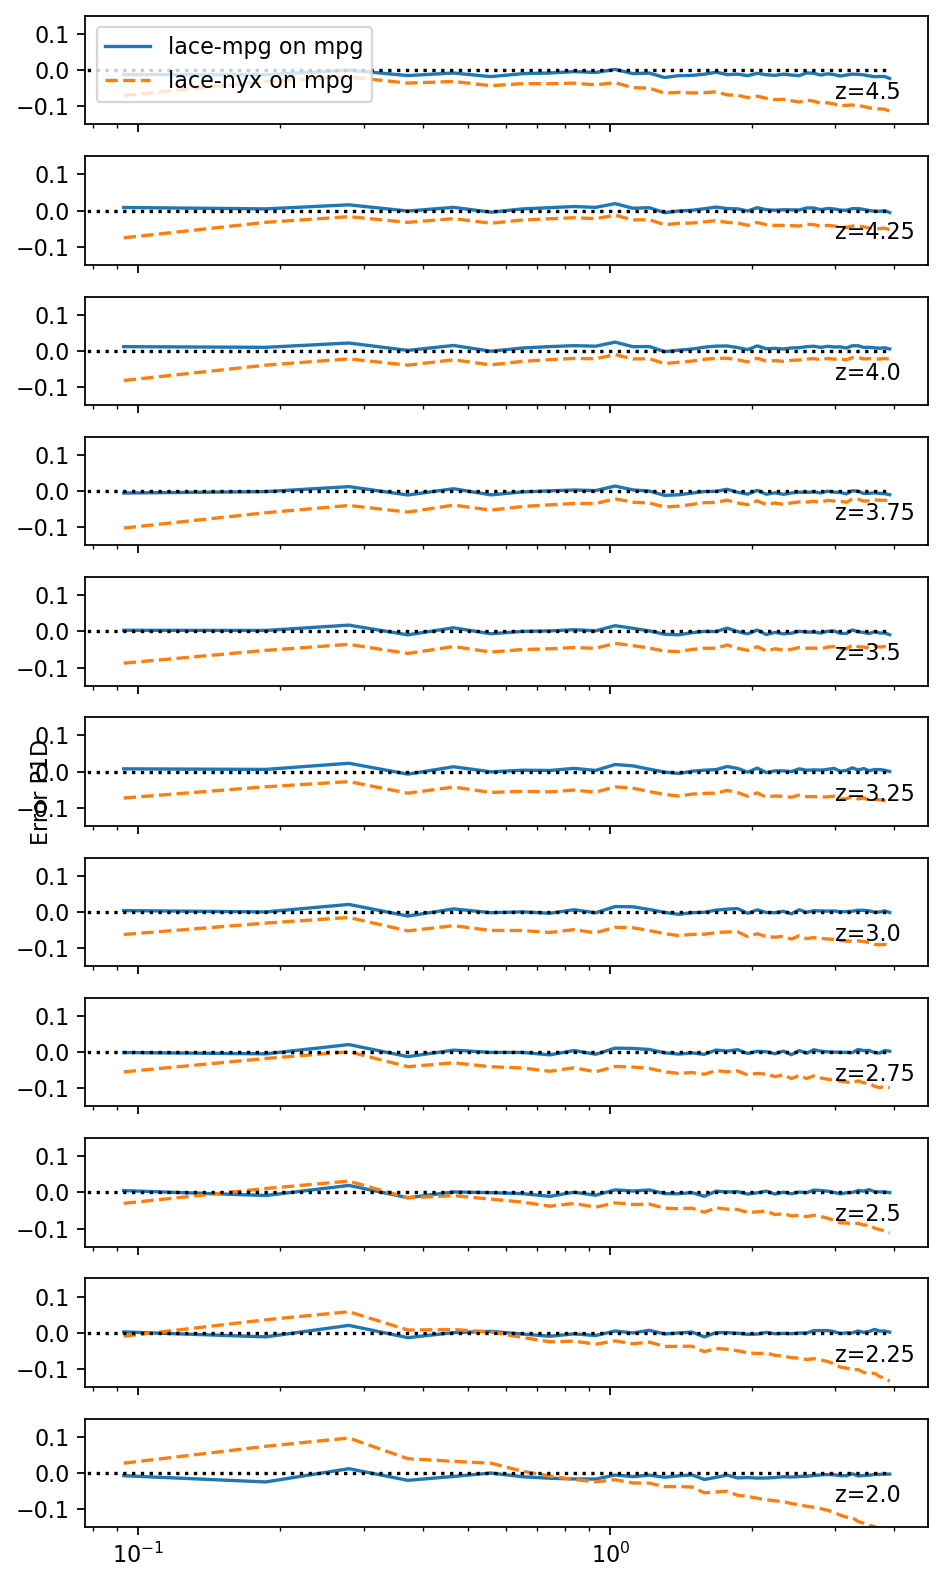

In [54]:
fig, ax = plt.subplots(len(mpg_central), figsize=(6, 10), sharex=True)

for iz in range(len(mpg_central)):
    # for iz in range(1):
    lab = "z=" + str(mpg_central[iz]["z"])

    emu_mpg = emulator_mpg.emulate_p1d_Mpc(
        mpg_central[iz], mpg_central[iz]["k_Mpc"], z=mpg_central[iz]["z"]
    )

    emu_nyx = emulator_nyx.emulate_p1d_Mpc(
        mpg_central[iz], mpg_central[iz]["k_Mpc"], z=mpg_central[iz]["z"]
    )
    k = mpg_central[iz]["k_Mpc"]
    pk = mpg_central[iz]["p1d_Mpc"]
    mask = k < 4

    ax[iz].plot(k[mask], emu_mpg[mask] / pk[mask] - 1, label="lace-mpg on mpg")
    color1 = line1.get_color()
    ax[iz].plot(
        k[mask],
        emu_nyx[mask] / pk[mask] - 1,
        "--",
        label="lace-nyx on mpg",
    )
    ax[iz].plot(k[mask], np.zeros_like(k[mask]), "k:")

    ax[iz].set_ylim(-0.15, 0.15)
    if iz == 0:
        ax[iz].legend()
    ax[iz].text(3, -0.08, lab)

fig.text(0.04, 0.5, "Error P1D", va="center", rotation="vertical")
plt.xscale("log")
plt.tight_layout()
folder = os.environ["LYA_DATA_PATH"] + "lace/"
plt.savefig(folder + "p1d_emus_mpg.pdf")
plt.savefig(folder + "p1d_emus_mpg.png")

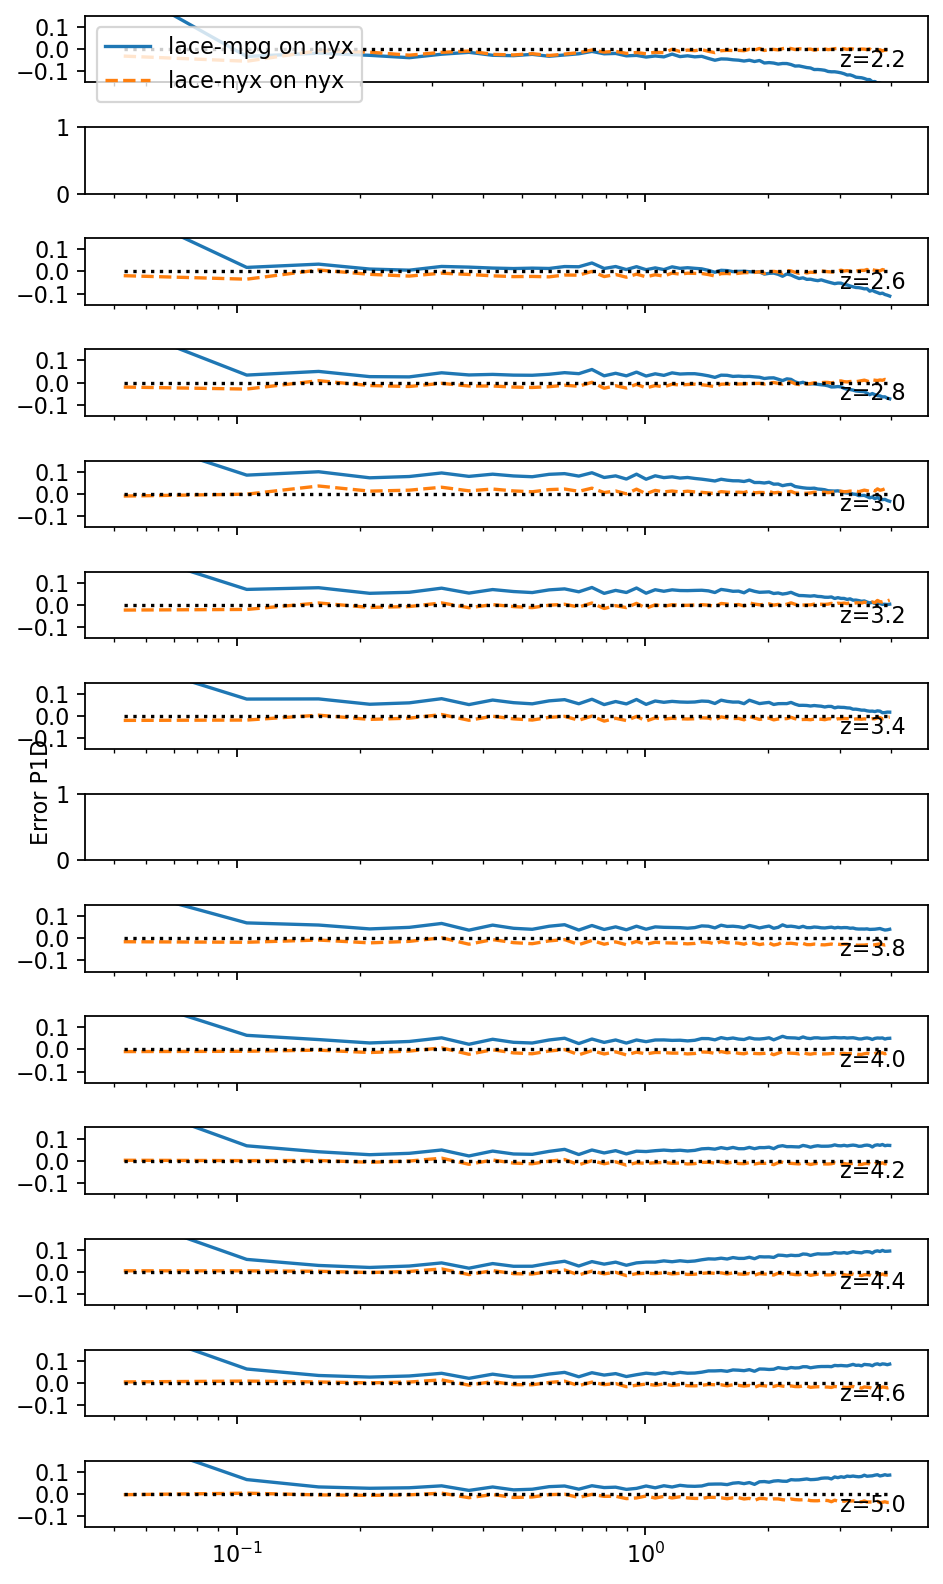

In [80]:
fig, ax = plt.subplots(len(nyx_central) - 1, figsize=(6, 10), sharex=True)

z_mpg = []
for iz in range(len(mpg_central)):
    z_mpg.append(mpg_central[iz]["z"])
z_mpg = np.array(z_mpg)

for iz in range(len(nyx_central) - 1):
    # for iz in range(1):

    if "kF_Mpc" not in nyx_central[iz]:
        continue
    lab = "z=" + str(np.round(nyx_central[iz]["z"], 2))

    input_emu = nyx_central[iz].copy()
#     indz = np.argmin(np.abs(z_mpg - nyx_central[iz]["z"]))
#     input_emu["kF_Mpc"] = mpg_central[indz]["kF_Mpc"]
    emu_mpg = emulator_mpg.emulate_p1d_Mpc(
        input_emu, nyx_central[iz]["k_Mpc"], z=nyx_central[iz]["z"]
    )

    input_emu = nyx_central[iz].copy()
    emu_nyx = emulator_nyx.emulate_p1d_Mpc(
        input_emu, nyx_central[iz]["k_Mpc"], z=nyx_central[iz]["z"]
    )

    k = nyx_central[iz]["k_Mpc"]
    pk = nyx_central[iz]["p1d_Mpc"]
    mask = k < 4

    ax[iz].plot(k[mask], emu_mpg[mask] / pk[mask] - 1, label="lace-mpg on nyx")
    color1 = line1.get_color()
    ax[iz].plot(
        k[mask],
        emu_nyx[mask] / pk[mask] - 1,
        "--",
        label="lace-nyx on nyx",
    )
    ax[iz].plot(k[mask], np.zeros_like(k[mask]), "k:")

    ax[iz].set_ylim(-0.15, 0.15)
    if iz == 0:
        ax[iz].legend()
    ax[iz].text(3, -0.08, lab)

fig.text(0.04, 0.5, "Error P1D", va="center", rotation="vertical")
plt.xscale("log")
plt.tight_layout()
folder = os.environ["LYA_DATA_PATH"] + "lace/"
# plt.savefig(folder + "p1d_emus_nyx.pdf")
plt.savefig(folder + "p1d_emus_nyx2.png")

### IGM histories

In [58]:
fname = (
    os.environ["LACE_REPO"]
    + "/src/lace/data/sim_suites/Australia20/IGM_histories.npy"
)
igm_mpg = np.load(fname, allow_pickle=True).item()

fname = os.environ["NYX_PATH"] + "/IGM_histories.npy"
igm_nyx = np.load(fname, allow_pickle=True).item()

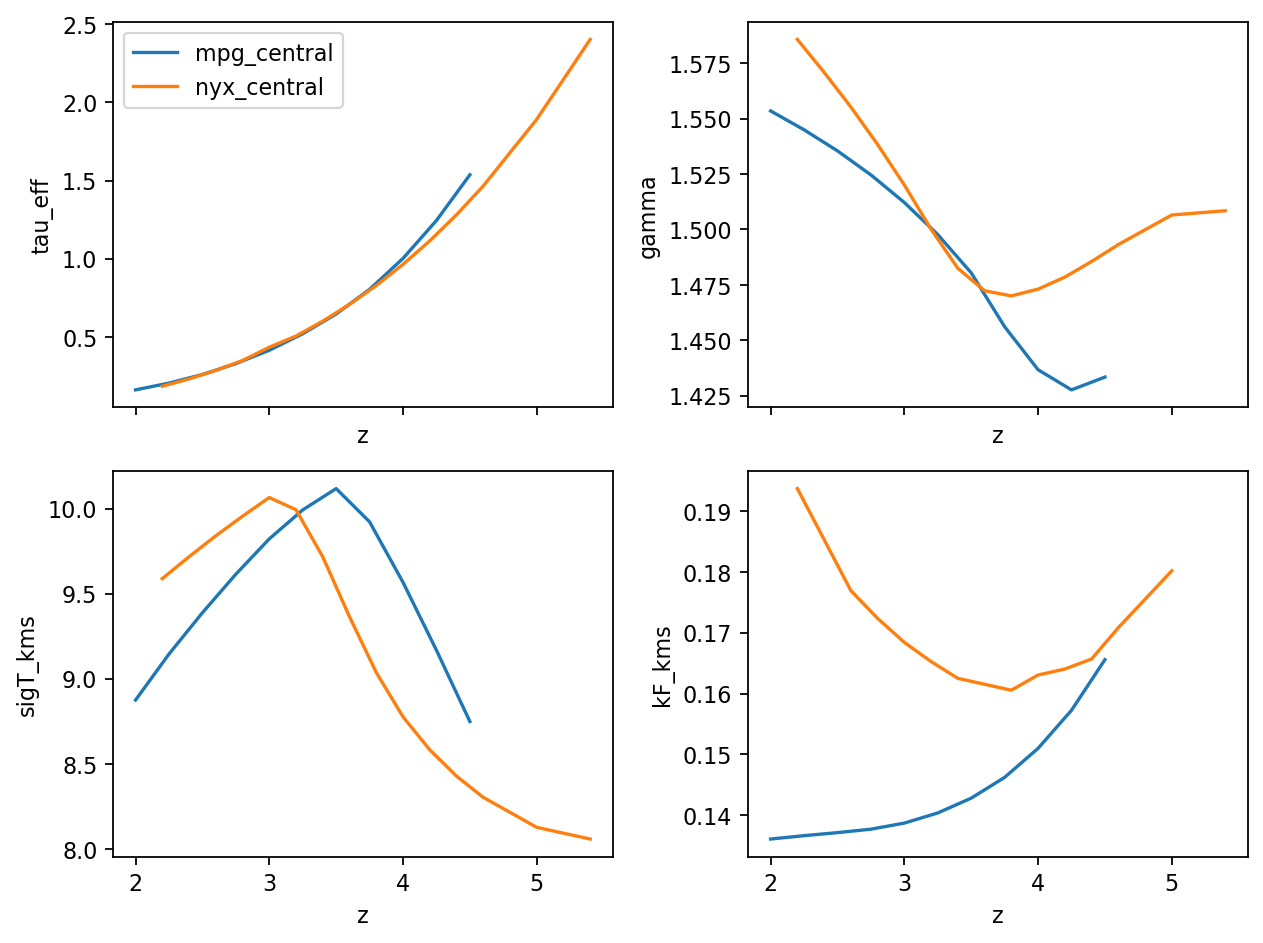

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
ax = ax.reshape(-1)
ii = 0
for par in igm_mpg["mpg_central"]:
    if par == "z":
        continue
    ax[ii].plot(
        igm_mpg["mpg_central"]["z"],
        igm_mpg["mpg_central"][par],
        label="mpg_central",
    )
    _ = igm_nyx["nyx_central"][par] != 0
    ax[ii].plot(
        igm_nyx["nyx_central"]["z"][_],
        igm_nyx["nyx_central"][par][_],
        label="nyx_central",
    )
    if ii == 0:
        ax[ii].legend()
    ax[ii].set_xlabel("z")
    ax[ii].set_ylabel(par)
    ii += 1
plt.tight_layout()
folder = os.environ["LYA_DATA_PATH"] + "lace/"
plt.savefig(folder + "igm_mpg_nyx.pdf")
plt.savefig(folder + "igm_mpg_nyx.png")

## Compare sims with obs data

### Check redshifts

In [6]:
mpg_z = []
for sim in mpg_central:
    mpg_z.append(sim["z"])
mpg_z = np.array(mpg_z)

nyx_z = []
for sim in nyx_central:
    nyx_z.append(sim["z"])
nyx_z = np.array(nyx_z)

In [7]:
print(datasets[0]["data"].z)
print(datasets[1]["data"].z)
print(mpg_z[::-1])
print(nyx_z)

[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6]
[2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6]
[2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.   4.25 4.5 ]
[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6 5.  5.4]


In [8]:
z_common = np.array([2.2, 3, 4])

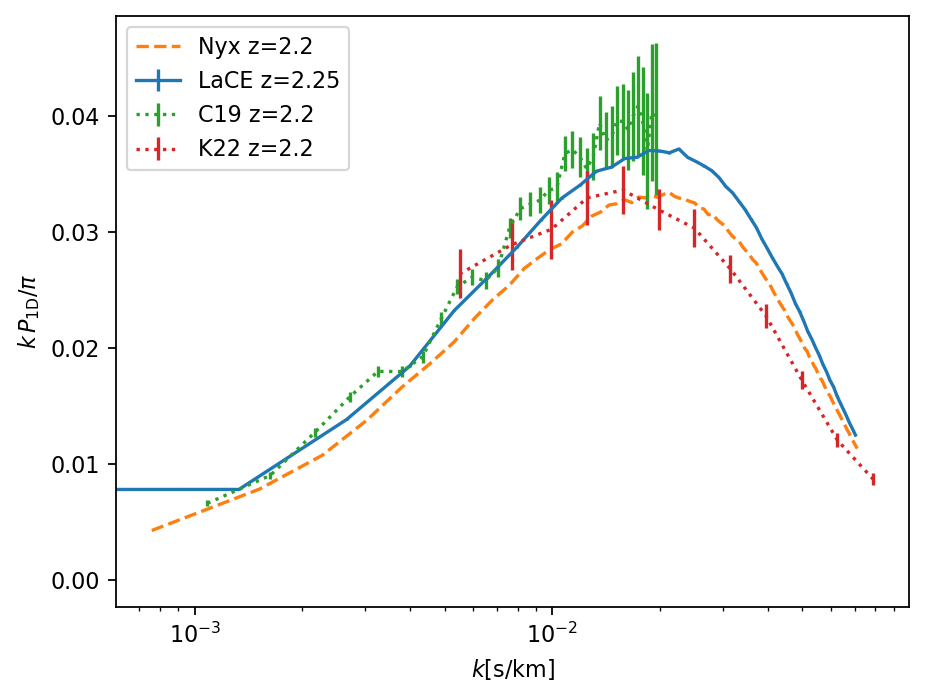

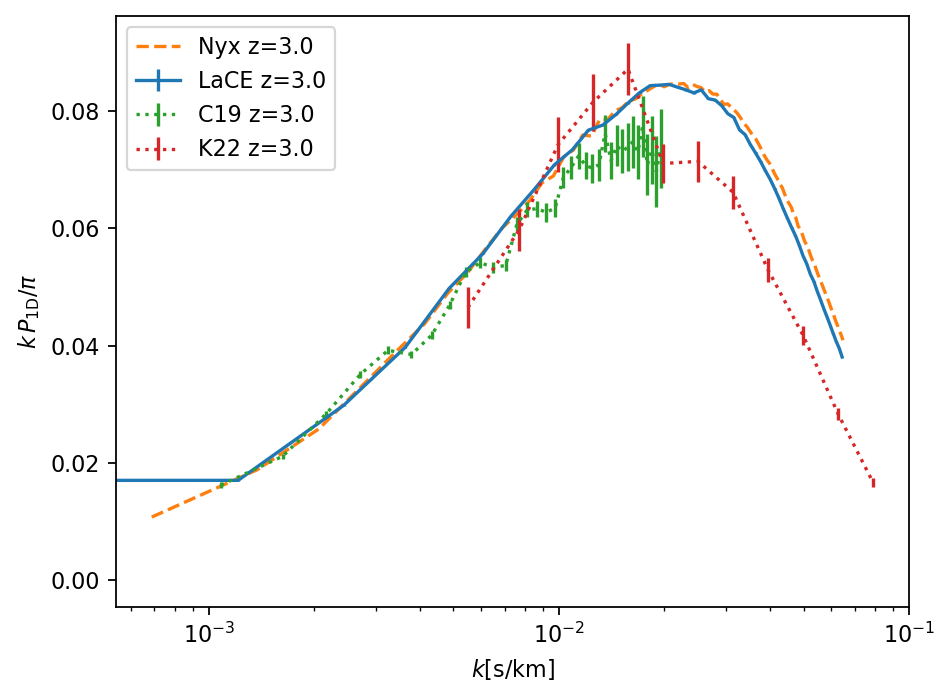

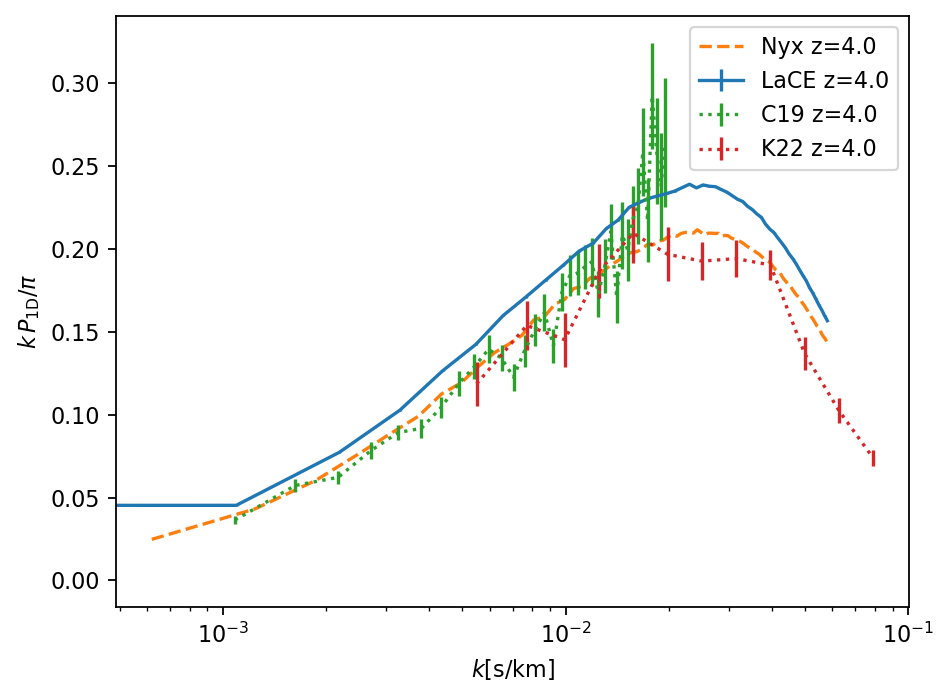

In [10]:
for ztarget in z_common:
    fig, ax = plt.subplots()

    # lace
    ii = np.argmin(np.abs(mpg_z - ztarget))
    mask = mpg_central[ii]["k_Mpc"] < 5
    conv_dkms_dMpc = mpg_central[ii]["dkms_dMpc"]
    k = mpg_central[ii]["k_Mpc"][mask]
    pk = mpg_central[ii]["p1d_Mpc"][mask]
    norm = k / np.pi
    std = err_mpg[mask] * pk
    ax.errorbar(
        k / conv_dkms_dMpc,
        norm * pk,
        norm * std,
        label="LaCE z=" + str(mpg_z[ii]),
    )
    #     if ztarget == 2.2:
    #         ii = ii + 1
    #         mask = mpg_central[ii]["k_Mpc"] < 5
    #         conv_dkms_dMpc = mpg_central[ii]["dkms_dMpc"]
    #         k = mpg_central[ii]["k_Mpc"][mask]
    #         pk = mpg_central[ii]["p1d_Mpc"][mask]
    #         norm = k / np.pi
    #         ax.plot(
    #             k / conv_dkms_dMpc,
    #             norm * pk,
    #             "C0:",
    #             label="LaCE z=" + str(mpg_z[ii]),
    #         )

    # nyx
    ii = np.argmin(np.abs(nyx_z - ztarget))
    mask = nyx_central[ii]["k_Mpc"] < 5
    conv_dkms_dMpc = nyx_central[ii]["dkms_dMpc"]
    k = nyx_central[ii]["k_Mpc"][mask]
    pk = nyx_central[ii]["p1d_Mpc"][mask]
    norm = k / np.pi
    ax.plot(
        k / conv_dkms_dMpc, norm * pk, "--", label="Nyx z=" + str(nyx_z[ii])
    )

    # eBOSS
    ii = np.argmin(np.abs(datasets[0]["data"].z - ztarget))
    k_kms = datasets[0]["data"].k_kms
    pk = datasets[0]["data"].get_Pk_iz(ii)
    err_pk = np.sqrt(np.diag(datasets[0]["data"].get_cov_iz(ii)))
    norm = k_kms / np.pi
    ax.errorbar(
        k_kms,
        norm * pk,
        norm * err_pk,
        ls=":",
        label="C19 z=" + str(datasets[0]["data"].z[ii]),
    )

    # high
    ii = np.argmin(np.abs(datasets[1]["data"].z - ztarget))
    k_kms = datasets[1]["data"].k_kms
    pk = datasets[1]["data"].get_Pk_iz(ii)
    err_pk = np.sqrt(np.diag(datasets[1]["data"].get_cov_iz(ii)))
    norm = k_kms / np.pi
    ax.errorbar(
        k_kms,
        norm * pk,
        norm * err_pk,
        ls=":",
        label="K22 z=" + str(datasets[1]["data"].z[ii]),
    )

    ax.set_xscale("log")
    ax.set_xlabel(r"$k$[s/km]")
    ax.set_ylabel(r"$k\,P_{\rm 1D}/\pi$")
    plt.legend()
#     plt.savefig('comparison_z'+str(ztarget)+'.png')
#     plt.savefig('comparison_z'+str(ztarget)+'.pdf')